In [899]:
import skimage.filters
import skimage.io
import scipy.signal
import scipy.ndimage
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [900]:
def plot(fn, ndim, **kwargs):
  if ndim == 2:
    fig = plt.figure(figsize=(10,4.5),)
    gs = mpl.gridspec.GridSpec(4, 4, height_ratios=[1, 0.05, 1, 0.05])
    ax  = [fig.add_subplot(gs[0,i]) for i in range(4)]
    cax1 = fig.add_subplot(gs[1,:])
    ax2 = [fig.add_subplot(gs[2,i]) for i in range(1, 4)]
    cax2 = fig.add_subplot(gs[3,1:])
  else:
    fig = plt.figure(figsize=(12,3),)
    gs = mpl.gridspec.GridSpec(1, 4)
    ax = [fig.add_subplot(gs[0,i]) for i in range(4)]

  ax[0].set_title("Original")
  ax[1].set_title("After cut at threshold")
  ax[2].set_title("After cut at threshold\nand adding sum of cutted values.")
  ax[3].set_title("After scaling")
  mult_c = kwargs.get("mult_c", None)
  add_c = kwargs.get("add_c", None)
  if "mult_c" in kwargs:
    kwargs["mult_c"] = None
  if "add_c" in kwargs:
    kwargs["add_c"] = None

  res1 = fn(**{**kwargs, "z": None})
  res2 = fn(**kwargs)
  res3 = fn(**{**kwargs, "add": True})
  res4 = fn(**{**kwargs, "add": True, "mult_c": mult_c, "add_c": add_c})

  vmax = max(np.max(res1["after"]),
             np.max(res2["after"]),
             np.max(res3["after"]),
             np.max(res4["after"]),)
  vmin = min(np.min(res1["after"]),
             np.min(res2["after"]),
             np.min(res3["after"]),
             np.min(res4["after"]),)
  print("vmin: ", vmin)
  print("vmax: ", vmax)
  if ndim == 1:
    ax[0].set_ylim(vmin, vmax)
    ax[1].set_ylim(vmin, vmax)
    ax[2].set_ylim(vmin, vmax)
    ax[3].set_ylim(vmin, vmax)
    ax[0].plot(range(res1["size"]), res1["before"], label="before")
    ax[0].plot(range(res1["size"]), res1["after"], label="after")
    ax[1].plot(range(res2["size"]), res2["before"], label="before")
    ax[1].plot(range(res2["size"]), res2["after"], label="after")
    ax[2].plot(range(res3["size"]), res3["before"], label="before")
    ax[2].plot(range(res3["size"]), res3["after"], label="after")
    ax[3].plot(range(res4["size"]), res4["before"], label="before")
    ax[3].plot(range(res4["size"]), res4["after"], label="after")
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    ax[3].legend()
  else:
    cmap = mpl.cm.get_cmap("jet")
    cmap.set_bad(color="white", alpha=1.0)
    g1 = res1["after"]
    g1m = np.ma.masked_array(g1, g1 == 0.0)
    g2 = res2["after"]
    g2m = np.ma.masked_array(g2, g2 == 0.0)
    g3 = res3["after"]
    g3m = np.ma.masked_array(g3, g3 == 0.0)
    g4 = res4["after"]
    g4m = np.ma.masked_array(g4, g4 == 0.0)
    norm1 = mpl.colors.Normalize()
    norm2 = mpl.colors.LogNorm()
    im1 = mpl.cm.ScalarMappable(norm=norm1, cmap=cmap)
    im2 = mpl.cm.ScalarMappable(norm=norm2, cmap=cmap)
    ax[0].imshow(g1m, cmap=cmap)
    ax[1].imshow(g2m, cmap=cmap, norm=norm1,)
    ax[2].imshow(g3m, cmap=cmap, norm=norm1,)
    ax[3].imshow(g4m, cmap=cmap, norm=norm1,)
    fig.colorbar(im1, cax=cax1, orientation="horizontal")
    ax2[0].imshow(g2m, cmap=cmap, norm=norm2,)
    ax2[1].imshow(g3m, cmap=cmap, norm=norm2,)
    ax2[2].imshow(g4m, cmap=cmap, norm=norm2,)
    fig.colorbar(im2, cax=cax2, orientation="horizontal")

  fig.suptitle("Size: {}, Sigma: {}, Z-score: {}, AddC: {}, MultC: {}".format(
      res1["size"],
      res2["sigma"],
      res3["z"],
      add_c,
      mult_c,
  ))
  fig.tight_layout()

# 1D

In [901]:
def oned(*, size = 31, sigma = 5.0, z = 1.0,
         mult_c = None, add_c = None, add = False):
  if size % 2 == 0:
    size += 1
  signal = np.zeros(size)
  signal[size // 2 + 1] = 1.0
  gauss = skimage.filters.gaussian(signal, sigma, mode="nearest")
  mean = np.mean(gauss)
  std = np.std(gauss)

  thresh = None

  before = gauss.copy()

  if z is not None:
    thresh = mean + (z * std)
    if add:
      gauss[gauss >= thresh] += np.sum(gauss[gauss < thresh]) / (len(gauss[gauss >= thresh]) or 1)
    gauss[gauss < thresh] = 0.0

  if mult_c is not None:
    gauss *= mult_c
  if add_c is not None:
    gauss[gauss > 0.0] += add_c
  s = np.sum(gauss)
  print("Sum: ", s)
  if add_c is not None or mult_c is not None:
    if add_c is not None:
      s -= np.sum(np.where(gauss > 0.0, add_c, 0.0))
    if mult_c is not None:
      s /= mult_c
    print("Sum (corrected): ", s)
  return dict(size=size, sigma=sigma, z=z, mult_c=mult_c, add_c=add_c,
              before=before, after=gauss)


## No thresholding

Sum:  0.997728762267547
Sum:  0.997728762267547
Sum:  0.997728762267547
Sum:  16.49772876226755
Sum (corrected):  0.997728762267549
vmin:  0.00047683676839285137
vmax:  0.5797916568879506


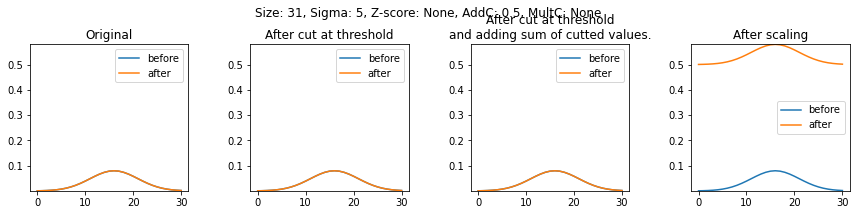

In [902]:
plot(oned, 1, size=31, sigma=5, z=None, add_c=0.5)

Sum:  0.997728762267547
Sum:  0.997728762267547
Sum:  0.997728762267547
Sum:  1.995457524535094
Sum (corrected):  0.997728762267547
vmin:  0.00047683676839285137
vmax:  0.15958331377590118


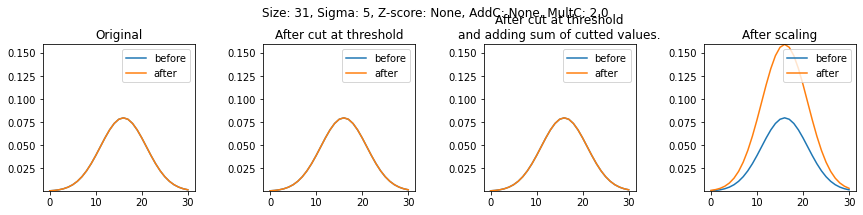

In [903]:
plot(oned, 1, size=31, sigma=5, z=None, mult_c=2.0)

Sum:  0.997728762267547
Sum:  0.997728762267547
Sum:  0.997728762267547
Sum:  17.495457524535095
Sum (corrected):  0.9977287622675473
vmin:  0.00047683676839285137
vmax:  0.6595833137759012


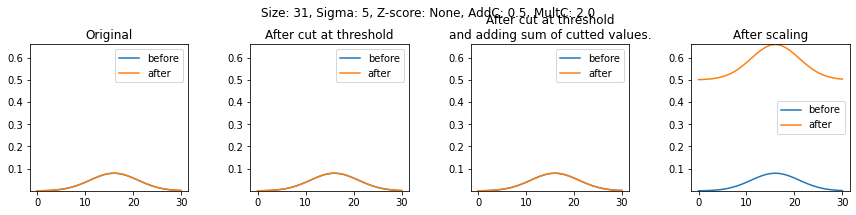

In [904]:
plot(oned, 1, size=31, sigma=5, z=None, add_c=0.5, mult_c=2.0)

## Thresholding with z-score = 0.5

Sum:  0.997728762267547
Sum:  0.7294976053403999
Sum:  0.997728762267547
Sum:  6.497728762267547
Sum (corrected):  0.9977287622675473
vmin:  0.0
vmax:  0.6041763075176912


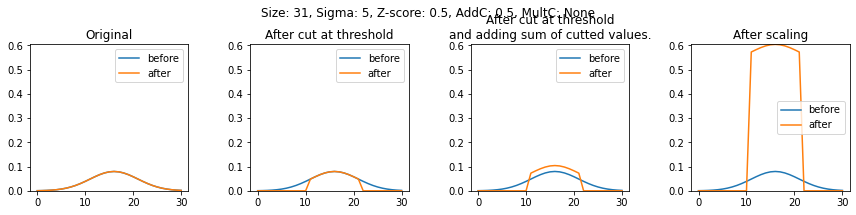

In [905]:
plot(oned, 1, size=31, sigma=5, z=0.5, add_c=0.5)

Sum:  0.997728762267547
Sum:  0.7294976053403999
Sum:  0.997728762267547
Sum:  1.995457524535094
Sum (corrected):  0.997728762267547
vmin:  0.0
vmax:  0.2083526150353825


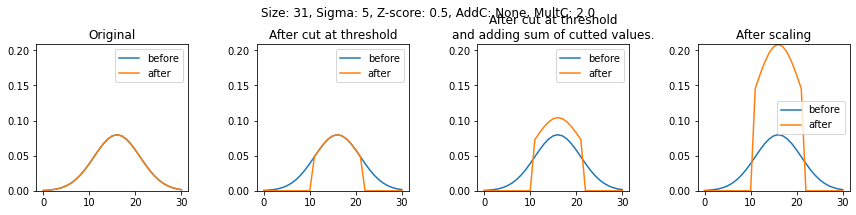

In [906]:
plot(oned, 1, size=31, sigma=5, z=0.5, mult_c=2.0)

Sum:  0.997728762267547
Sum:  0.7294976053403999
Sum:  0.997728762267547
Sum:  7.4954575245350945
Sum (corrected):  0.9977287622675473
vmin:  0.0
vmax:  0.7083526150353825


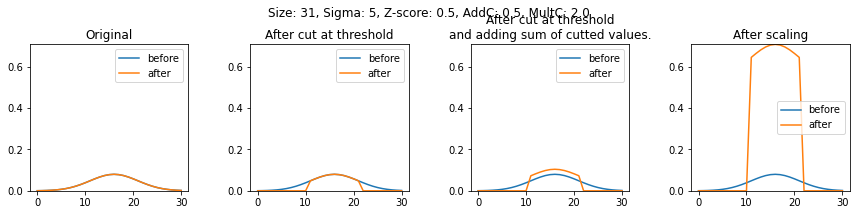

In [907]:
plot(oned, 1, size=31, sigma=5, z=0.5, add_c=0.5, mult_c=2.0)

## Thresholding with z-score = 1

Sum:  0.997728762267547
Sum:  0.5168241631253749
Sum:  0.9977287622675469
Sum:  4.497728762267547
Sum (corrected):  0.9977287622675473
vmin:  0.0
vmax:  0.6484923139082609


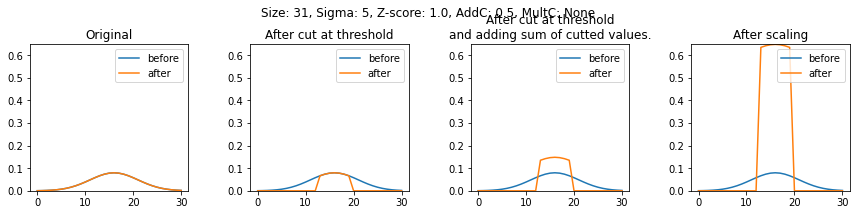

In [908]:
plot(oned, 1, size=31, sigma=5, z=1.0, add_c=0.5)

Sum:  0.997728762267547
Sum:  0.5168241631253749
Sum:  0.9977287622675469
Sum:  1.9954575245350938
Sum (corrected):  0.9977287622675469
vmin:  0.0
vmax:  0.2969846278165218


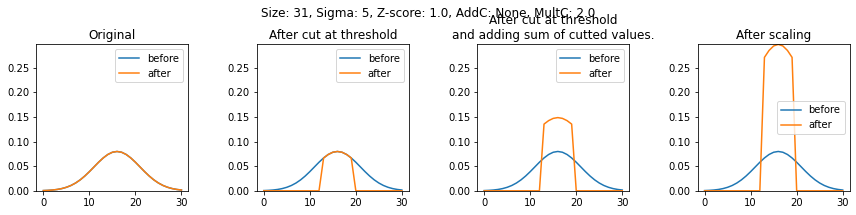

In [909]:
plot(oned, 1, size=31, sigma=5, z=1.0, mult_c=2.0)

Sum:  0.997728762267547
Sum:  0.5168241631253749
Sum:  0.9977287622675469
Sum:  5.495457524535094
Sum (corrected):  0.9977287622675468
vmin:  0.0
vmax:  0.7969846278165218


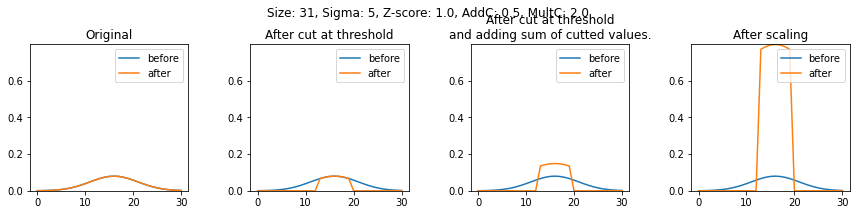

In [910]:
plot(oned, 1, size=31, sigma=5, z=1.0, add_c=0.5, mult_c=2.0)

# 2D

In [911]:
def twod(*, size = 31, sigma = 5.0, z = None, mult_c = None,
         add_c = None, add = False):
  if size % 2 == 0:
    size += 1
  mean_idx = size // 2 + 1
  signal = np.zeros((size, size))
  signal[mean_idx, mean_idx] = 1.0
  gauss = skimage.filters.gaussian(signal, sigma, mode="nearest")
  
  if z is not None:
    mean = np.mean(gauss)
    std = np.std(gauss)
    thresh = mean + (z * std)
    throw_idx = gauss < thresh
    keep_idx = np.logical_not(throw_idx)
    if add:
      gauss[keep_idx] += np.sum(gauss[throw_idx]) / (len(gauss[keep_idx]) or 1.0)
    gauss[throw_idx] = 0.0

  if mult_c is not None:
    gauss *= mult_c
  if add_c is not None:
    print("Adding")
    gauss[gauss > 0.0] += add_c

  s = np.sum(gauss)
  print("Sum: ", s)

  if add_c is not None or mult_c is not None:
    if add_c is not None:
      s -= np.sum(np.where(gauss > 0.0, add_c, 0.0))
    if mult_c is not None:
      s /= mult_c
    print("Sum (corrected): ", s)
  return dict(size=size, sigma=sigma, z=z, mult_c=mult_c, add_c=add_c,
              after=gauss)

## No scaling

Sum:  0.9954626830559312
Sum:  0.9954626830559312
Sum:  0.9954626830559312
Sum:  0.9954626830559312
vmin:  2.2737330369133778e-07
vmax:  0.0063667085089244325


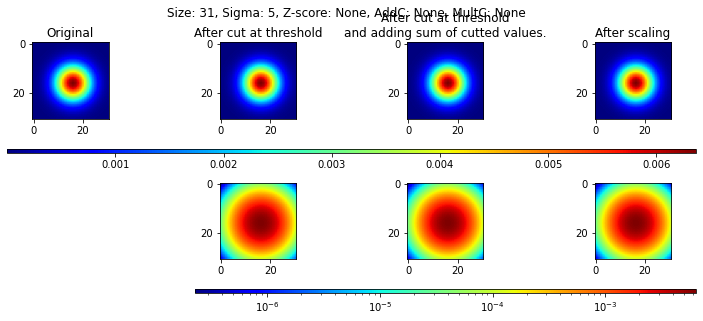

In [912]:
plot(twod, 2, size=31, sigma=5, z=None)

Sum:  0.9954626830559312
Sum:  0.7074066132480041
Sum:  0.9954626830559313
Sum:  0.9954626830559313
vmin:  0.0
vmax:  0.007859227005338563


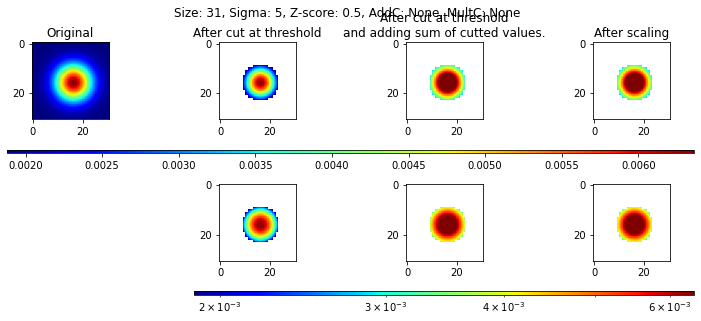

In [913]:
plot(twod, 2, size=31, sigma=5, z=0.5)

Sum:  0.9954626830559312
Sum:  0.6030892886586839
Sum:  0.9954626830559312
Sum:  0.9954626830559312
vmin:  0.0
vmax:  0.00907273191856062


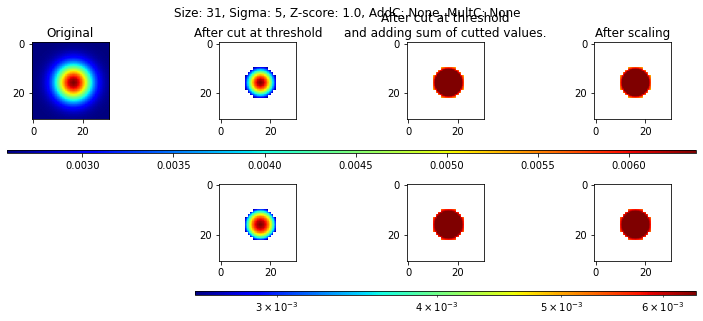

In [914]:
plot(twod, 2, size=31, sigma=5, z=1.0)

## Additive scaling only

Sum:  0.9954626830559312
Sum:  0.9954626830559312
Sum:  0.9954626830559312
Adding
Sum:  481.4954626830559
Sum (corrected):  0.995462683055905
vmin:  2.2737330369133778e-07
vmax:  0.5063667085089244


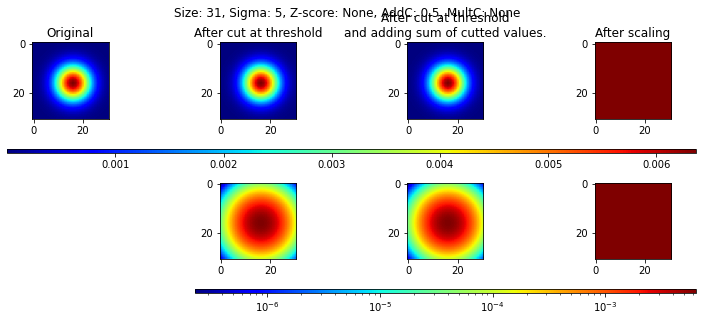

In [915]:
plot(twod, 2, size=31, sigma=5, z=None, add_c=0.5)

Sum:  0.9954626830559312
Sum:  0.7074066132480041
Sum:  0.9954626830559313
Adding
Sum:  97.49546268305593
Sum (corrected):  0.9954626830559334
vmin:  0.0
vmax:  0.5078592270053386


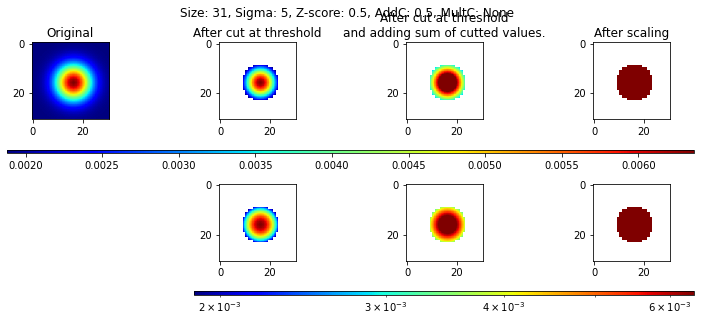

In [916]:
plot(twod, 2, size=31, sigma=5, z=0.5, add_c=0.5)

Sum:  0.9954626830559312
Sum:  0.6030892886586839
Sum:  0.9954626830559312
Adding
Sum:  73.49546268305593
Sum (corrected):  0.9954626830559334
vmin:  0.0
vmax:  0.5090727319185606


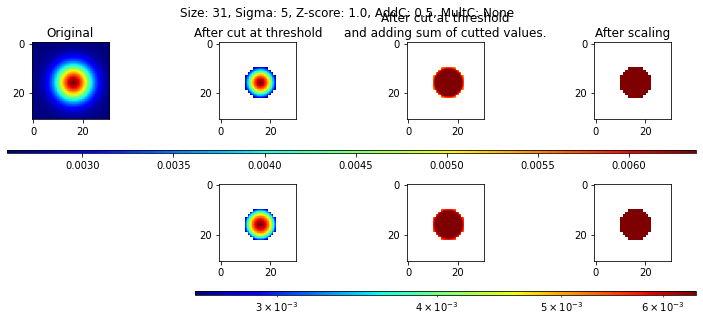

In [917]:
plot(twod, 2, size=31, sigma=5, z=1.0, add_c=0.5)

## Multiplicative scaling only

Sum:  0.9954626830559312
Sum:  0.9954626830559312
Sum:  0.9954626830559312
Sum:  99.54626830559312
Sum (corrected):  0.9954626830559312
vmin:  2.2737330369133778e-07
vmax:  0.6366708508924432


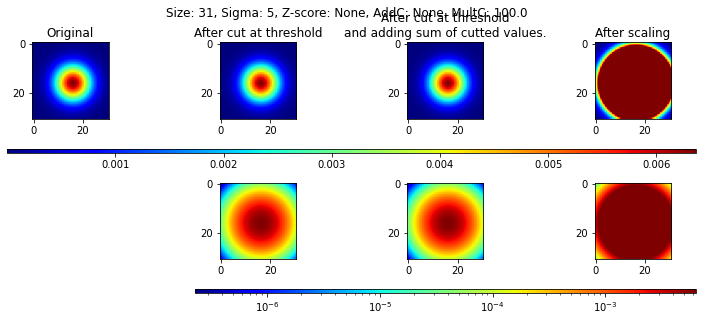

In [918]:
plot(twod, 2, size=31, sigma=5, z=None, mult_c=100.)

Sum:  0.9954626830559312
Sum:  0.7074066132480041
Sum:  0.9954626830559313
Sum:  99.54626830559312
Sum (corrected):  0.9954626830559312
vmin:  0.0
vmax:  0.7859227005338563


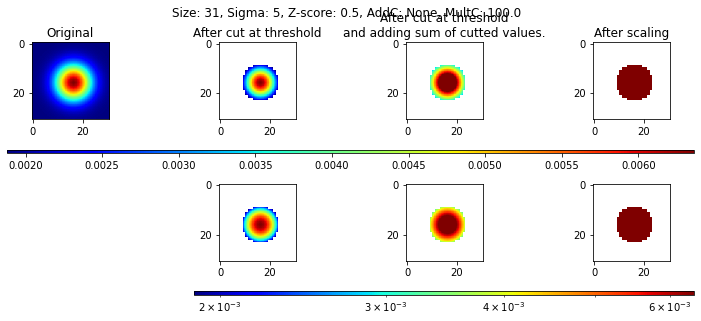

In [919]:
plot(twod, 2, size=31, sigma=5, z=0.5, mult_c=100.)

Sum:  0.9954626830559312
Sum:  0.6030892886586839
Sum:  0.9954626830559312
Sum:  99.54626830559312
Sum (corrected):  0.9954626830559312
vmin:  0.0
vmax:  0.907273191856062


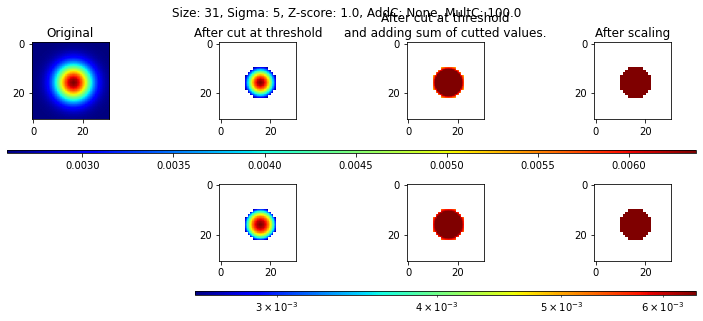

In [920]:
plot(twod, 2, size=31, sigma=5, z=1.0, mult_c=100.)

## Multiplicative and additive scaling

Sum:  0.9954626830559312
Sum:  0.9954626830559312
Sum:  0.9954626830559312
Adding
Sum:  580.0462683055932
Sum (corrected):  0.9954626830559323
vmin:  2.2737330369133778e-07
vmax:  1.1366708508924432


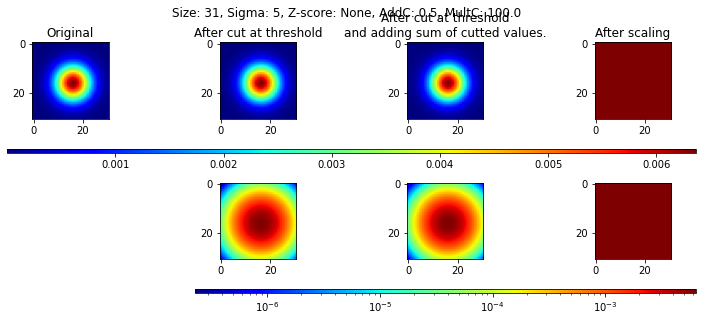

In [921]:
plot(twod, 2, size=31, sigma=5, z=None, mult_c=100.0, add_c=0.5)

Sum:  0.9954626830559312
Sum:  0.7074066132480041
Sum:  0.9954626830559313
Adding
Sum:  196.04626830559312
Sum (corrected):  0.9954626830559312
vmin:  0.0
vmax:  1.2859227005338563


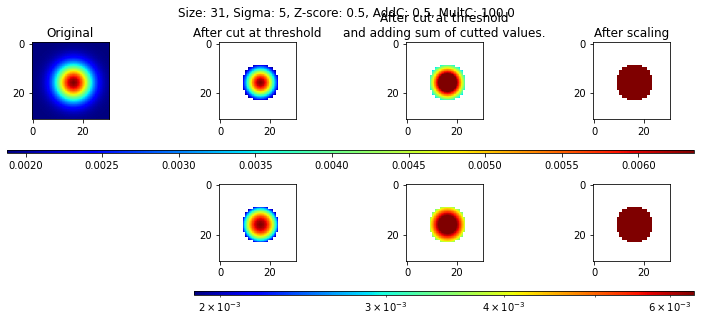

In [922]:
plot(twod, 2, size=31, sigma=5, z=0.5, mult_c=100.0, add_c=0.5)

Sum:  0.9954626830559312
Sum:  0.6030892886586839
Sum:  0.9954626830559312
Adding
Sum:  172.04626830559312
Sum (corrected):  0.9954626830559312
vmin:  0.0
vmax:  1.4072731918560621


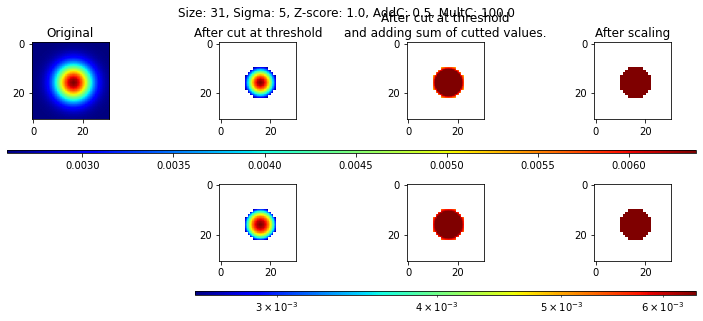

In [923]:
plot(twod, 2, size=31, sigma=5, z=1.0, mult_c=100.0, add_c=0.5)